In [9]:
import pandas as pd
import numpy as np
from embeddings import GloveEmbedding, FastTextEmbedding, KazumaCharEmbedding, ConcatEmbedding
import matplotlib.pyplot as plt
from copy import deepcopy
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nlppreprocess import NLP
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pranavgajera/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pranavgajera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
glove_embeddings = GloveEmbedding('common_crawl_840', d_emb=300, show_progress=True,default='zero' )
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
nlp = NLP()
stopwords = nltk.corpus.stopwords.words("english")
negative_stopwords = ["no", "not", "never", "none", "nothing", "nobody"]
stopwords = [word for word in stopwords if word not in negative_stopwords]

In [3]:
def load_dataset(dataset=1):
    if(dataset==1):
        train_df = pd.read_excel('/Users/pranavgajera/Downloads/DLNLP/Assignment1/Dataset/ClassificationDataset-train0.xlsx',header=None).dropna()
        val_df = pd.read_excel('/Users/pranavgajera/Downloads/DLNLP/Assignment1/Dataset/ClassificationDataset-valid0.xlsx',header=None).dropna()
        train_df.columns = ['target','sentiment']
        val_df.columns = ['target','sentiment']
    elif(dataset==2):
        train_df = pd.read_excel('/Users/pranavgajera/Downloads/DLNLP/Assignment1/Dataset/ClassificationDataset-train1.xlsx').dropna()
        val_df = pd.read_excel('/Users/pranavgajera/Downloads/DLNLP/Assignment1/Dataset/ClassificationDataset-valid1.xlsx').dropna()
    elif(dataset==3):
        train_df = pd.read_excel('/Users/pranavgajera/Downloads/DLNLP/Assignment1/Dataset/ClassificationDataset-train2.xlsx').dropna()
        val_df = pd.read_excel('/Users/pranavgajera/Downloads/DLNLP/Assignment1/Dataset/ClassificationDataset-valid2.xlsx').dropna()
        
    return  train_df,val_df

In [4]:
def message_to_cummulative_embedding(message):
    tokens = tokenizer.tokenize(nlp.process(message))
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens]
    useful_words = [t for t in lemmatized_tokens if t.lower() not in stopwords]
    
    embedding_vector = np.zeros((glove_embeddings.d_emb))
    for word in useful_words:
        word_embedding = glove_embeddings.emb(word)
        embedding_vector = np.add(embedding_vector,word_embedding)
    
    return embedding_vector

    

In [5]:
def getDataset(dataset=1):
    train_df, val_df = load_dataset(dataset)

    X_train = train_df.iloc[:,1]
    y_train = train_df.iloc[:,0]
    X_val = val_df.iloc[:,1]
    y_val = val_df.iloc[:,0]

    if(dataset==1):
        y_train = [np.array([1,0,0]) if y=='negative' else np.array([0,1,0]) if y=='neutral' else np.array([0,0,1]) for y in y_train]
        y_val = [np.array([1,0,0]) if y=='negative' else np.array([0,1,0]) if y=='neutral' else np.array([0,0,1]) for y in y_val]
    elif(dataset==2):
        y_train = [np.array([1,0]) if y==0 else np.array([0,1]) for y in y_train]
        y_val = [np.array([1,0]) if y==0 else np.array([0,1]) for y in y_val]
    elif(dataset==3):
        y_train = [np.array([1,0,0,0,0]) if y==1 else np.array([0,1,0,0,0]) if y==2 else np.array([0,0,1,0,0]) if y==3 else np.array([0,0,0,1,0]) if y==4 else np.array([0,0,0,0,1]) for y in y_train]
        y_val = [np.array([1,0,0,0,0]) if y==1 else np.array([0,1,0,0,0]) if y==2 else np.array([0,0,1,0,0]) if y==3 else np.array([0,0,0,1,0]) if y==4 else np.array([0,0,0,0,1]) for y in y_val]

    X_train = [message_to_cummulative_embedding(m) for m in X_train]
    X_val = [message_to_cummulative_embedding(m) for m in X_val]

    return np.array(X_train),np.array(X_val),np.array(y_train),np.array(y_val)


In [6]:
class DANSentimentClassifier(nn.Module):
    def __init__(self,input_dim,hidden1_dim,hidden2_dim,hidden3_dim,drop_out1,drop_out2,drop_out3,num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim,hidden1_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(drop_out1)
        self.layer2 = nn.Linear(hidden1_dim,hidden2_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(drop_out2)
        self.layer3 = nn.Linear(hidden2_dim,hidden3_dim)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(drop_out3)
        self.out = nn.Linear(hidden3_dim,num_classes)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = F.softmax(self.out(x),dim=-1)
        return x

In [7]:
def train(model, train_data, val_data, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_accu = list()
    val_acuu = list()
    epoch_list = list()
    for epoch in range(epochs):
        epoch_list.append(epoch+1)
        correct = 0
        inputs, labels = train_data
        inputs = torch.tensor(inputs,dtype=torch.float32)
        labels = torch.tensor(labels,dtype=torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        predictions = outputs.argmax(dim=-1)
        labels = labels.argmax(dim=-1)
        correct += (predictions==labels).sum().item()
        train_accuracy = correct/inputs.shape[0]
        train_accu.append(train_accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss = 0
        correct = 0
        with torch.no_grad():
            inputs, labels = val_data
            inputs = torch.tensor(inputs,dtype=torch.float32)
            labels = torch.tensor(labels,dtype=torch.float32)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            predictions = outputs.argmax(dim=-1)
            labels = labels.argmax(dim=-1)
            correct += (predictions==labels).sum().item()
            val_accuracy = correct/inputs.shape[0]
            val_acuu.append(val_accuracy)
            f1_score = sklearn.metrics.f1_score(labels, predictions,average='micro')
            confusion_matrix = sklearn.metrics.confusion_matrix(labels, predictions)

        print(f"Epoch {epoch+1}/{epochs}: Train loss {loss}, Val loss {val_loss}, Train acc {train_accuracy} , Val acc {val_accuracy}, F1-Score {f1_score}")
    print("Confusion Matrix :")
    print(confusion_matrix)
    print()
    print(f"Epoch {epoch+1}/{epochs}: Train loss {loss}, Val loss {val_loss}, Train acc {train_accuracy} , Val acc {val_accuracy}, F1-Score {f1_score}")

    plt.plot(epoch_list, train_accu)
    plt.plot(epoch_list,val_acuu)
    plt.xlabel("Epochs") 
    plt.ylabel("Acccuracy") 
    plt.title(f"Train and Validation Accuracy for dataset {dataset}") 
    plt.legend(["Train","Validation"])
    plt.savefig(f'dataset_{dataset}.png')
    plt.show()



Epoch 1/350: Train loss 1.638727068901062, Val loss 1.5978288650512695, Train acc 0.10368251698248122 , Val acc 0.2006661115736886, F1-Score 0.2006661115736886
Epoch 2/350: Train loss 1.5936328172683716, Val loss 1.5442951917648315, Train acc 0.20843761172685019 , Val acc 0.4113238967527061, F1-Score 0.4113238967527061
Epoch 3/350: Train loss 1.5522042512893677, Val loss 1.500227928161621, Train acc 0.4004290311047551 , Val acc 0.5611990008326395, F1-Score 0.5611990008326395
Epoch 4/350: Train loss 1.5013766288757324, Val loss 1.4471617937088013, Train acc 0.5423668215945656 , Val acc 0.649458784346378, F1-Score 0.649458784346378
Epoch 5/350: Train loss 1.4418368339538574, Val loss 1.3819689750671387, Train acc 0.654987486592778 , Val acc 0.7110741049125728, F1-Score 0.7110741049125728
Epoch 6/350: Train loss 1.376856803894043, Val loss 1.3138515949249268, Train acc 0.7222023596710762 , Val acc 0.7485428809325562, F1-Score 0.7485428809325563
Epoch 7/350: Train loss 1.305350661277771, V

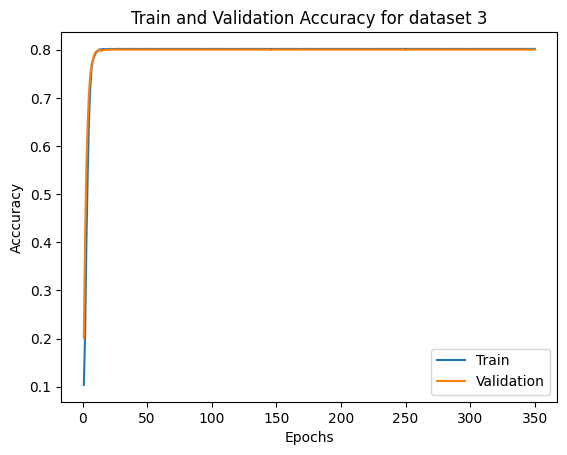

In [8]:
dataset = 3
X_train, X_val, y_train, y_val = getDataset(dataset)

train_data = (X_train,y_train)
val_data = (X_val,y_val)


input_dim = glove_embeddings.d_emb
hidden1_dim = 200
hidden2_dim = 100
hidden3_dim = 50 
drop_out1 = 0.5
drop_out2 = 0.5
drop_out3 = 0.5
num_calsses = 3 if dataset==1 else 2 if dataset==2 else 5


epochs = 350
lr = 0.001



model = DANSentimentClassifier(input_dim,hidden1_dim,hidden2_dim,hidden3_dim,drop_out1,drop_out2,drop_out3,num_calsses)


train(model,train_data,val_data,epochs,lr)